In [1]:
import torch 
import time
import numpy as np
from torchsummary import summary

from sde import VPSDE
from configs.config import CFGS
from models.unet import UNet
from sampling import get_sampler

## Model summary

In [2]:
model_config = CFGS["model"]
model = UNet(**model_config).to("cuda")

In [3]:
x = torch.randn((1,6,64,64), device="cuda")
t = torch.rand(x.shape[0], device="cuda")

summary(model, x, t)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256]                 --
|    └─Linear: 2-1                       [-1, 256]                 16,640
|    └─SiLU: 2-2                         [-1, 256]                 --
|    └─Linear: 2-3                       [-1, 256]                 65,792
├─ModuleList: 1                          []                        --
|    └─EmbedSequential: 2-4              [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 64, 64]          3,520
|    └─EmbedSequential: 2-5              [-1, 64, 64, 64]          --
|    |    └─ResBlock: 3-2                [-1, 64, 64, 64]          107,008
|    └─EmbedSequential: 2-6              [-1, 64, 64, 64]          --
|    |    └─ResBlock: 3-3                [-1, 64, 64, 64]          107,008
|    └─EmbedSequential: 2-7              [-1, 64, 32, 32]          --
|    |    └─ResBlock: 3-4                [-1, 64, 32, 32]       

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256]                 --
|    └─Linear: 2-1                       [-1, 256]                 16,640
|    └─SiLU: 2-2                         [-1, 256]                 --
|    └─Linear: 2-3                       [-1, 256]                 65,792
├─ModuleList: 1                          []                        --
|    └─EmbedSequential: 2-4              [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 64, 64]          3,520
|    └─EmbedSequential: 2-5              [-1, 64, 64, 64]          --
|    |    └─ResBlock: 3-2                [-1, 64, 64, 64]          107,008
|    └─EmbedSequential: 2-6              [-1, 64, 64, 64]          --
|    |    └─ResBlock: 3-3                [-1, 64, 64, 64]          107,008
|    └─EmbedSequential: 2-7              [-1, 64, 32, 32]          --
|    |    └─ResBlock: 3-4                [-1, 64, 32, 32]       

## Hardware Summary

In [2]:
print('__CUDA Device Name:',torch.cuda.get_device_name(0))
print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDA Device Name: NVIDIA GeForce RTX 2080 Ti
__CUDA Device Total Memory [GB]: 11.554586624


## Sampling time for different image sizes.

In [ ]:
# Define the sde
vpsde = VPSDE(N=10)

def sampler_time(model, img_size, total_steps):

    condition = torch.randn(1,3,img_size, img_size)
    condition = condition.to("cuda")
    sampling_fn = get_sampler(sde=vpsde, shape=condition.shape)
    times = list()
    
    for steps in total_steps:

        start = time.time()       
        with torch.no_grad():
            sample = sampling_fn(model, condition, num_steps=steps)
        end = time.time()
        elapsed = end - start
        times.append(elapsed)
        
    return times

In [ ]:
sampling_times = dict()

total_steps = [int(i) for i in list(np.linspace(10, 2000, 8))] 
total_steps

In [ ]:
# Config for 32 by 32 Image
CFGS["model"]["image_size"] = 32
model_config = CFGS["model"]
model_32 = UNet(**model_config).to("cuda")

times_32 = sampler_time(model_32, img_size=32, total_steps=total_steps)
sampling_times["32"] = times_32

In [ ]:
sampling_times

In [ ]:
CFGS["model"]["image_size"] = 64
model_config = CFGS["model"]
model_64 = UNet(**model_config).to("cuda")

times_64 = sampler_time(model_64, img_size=64, total_steps=total_steps)
sampling_times["64"] = times_64

In [ ]:
sampling_times

In [ ]:
CFGS["model"]["image_size"] = 128
model_config = CFGS["model"]
model_128 = UNet(**model_config).to("cuda")

times_128 = sampler_time(model_128, img_size=128, total_steps=total_steps)
sampling_times["128"] = times_128

In [ ]:
CFGS["model"]["image_size"] = 256
model_config = CFGS["model"]
model_256 = UNet(**model_config).to("cuda")

times_256 = sampler_time(model_256, img_size=256, total_steps=total_steps)
sampling_times["256"] = times_256

In [ ]:
sampling_times

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(total_steps, sampling_times["32"], marker='o', color='c', linewidth=2, label='$32~by~32$')
ax.plot(total_steps, sampling_times["64"], marker='o', color='y', linewidth=2,  label='$64~by~64$')
ax.plot(total_steps, sampling_times["128"], marker='o', linewidth=2,  label='$128~by~128$')
ax.plot(total_steps, sampling_times["256"], marker='o', linewidth=2,  label='$256~by~256$')
ax.set_title(label="Sampling time using EM Sampler", fontdict={'fontsize':14})
plt.xticks(total_steps)
ax.set_xlabel('N (Steps)')
ax.set_ylabel('Time (in sec)')
plt.legend()
plt.show()

## Memory consuption of the EM sampler

In [5]:
# Define the sde
vpsde = VPSDE(N=10)

def sampler_mem(model, img_size, total_steps, device=0, grad_track=True):
    
    model.to(device)
    condition = torch.randn(1,3,img_size, img_size)
    condition = condition.to(device)
    sampling_fn = get_sampler(sde=vpsde, shape=condition.shape)
    
    if grad_track:
        start = torch.cuda.memory_allocated(device)         
        sample = sampling_fn(model, condition, num_steps=total_steps)
        end = torch.cuda.memory_allocated(device)
    else: 
        with torch.no_grad():
            start = torch.cuda.memory_allocated(device)         
            sample = sampling_fn(model, condition, num_steps=total_steps)
            end = torch.cuda.memory_allocated(device)
        
    consumed = (end - start)/1e6
    print(f"Memory Consumption of sampler for img size:{img_size} and N steps:{total_steps} = {consumed}")
        
    return consumed

In [7]:
CFGS["model"]["image_size"] = 32
model_config = CFGS["model"]
model_32 = UNet(**model_config)

sampler_mem(model_32, img_size=32, total_steps=10)
sampler_mem(model_32, img_size=32, total_steps=50)
sampler_mem(model_32, img_size=32, total_steps=100, grad_track=False)
sampler_mem(model_32, img_size=32, total_steps=1000, grad_track=False)
sampler_mem(model_32, img_size=32, total_steps=1500, grad_track=False)

Memory Consumption of sampler for img size:32 and N steps:10 = 403.887616
Memory Consumption of sampler for img size:32 and N steps:50 = 2019.390976
Memory Consumption of sampler for img size:32 and N steps:100 = 0.012288
Memory Consumption of sampler for img size:32 and N steps:1000 = 0.012288
Memory Consumption of sampler for img size:32 and N steps:1500 = 0.012288


0.012288

In [8]:
CFGS["model"]["image_size"] = 64
model_config = CFGS["model"]
model_64 = UNet(**model_config)

sampler_mem(model_64, img_size=64, total_steps=10)
sampler_mem(model_64, img_size=64, total_steps=50)
sampler_mem(model_64, img_size=64, total_steps=100, grad_track=False)
sampler_mem(model_64, img_size=64, total_steps=500, grad_track=False)
sampler_mem(model_64, img_size=64, total_steps=1500, grad_track=False)

Memory Consumption of sampler for img size:64 and N steps:10 = 1610.97472
Memory Consumption of sampler for img size:64 and N steps:50 = 8060.970496
Memory Consumption of sampler for img size:64 and N steps:100 = 0.049152
Memory Consumption of sampler for img size:64 and N steps:500 = 0.049152
Memory Consumption of sampler for img size:64 and N steps:1500 = 0.049152


0.049152

In [9]:
CFGS["model"]["image_size"] = 128
model_config = CFGS["model"]
model_128 = UNet(**model_config)

sampler_mem(model_128, img_size=128, total_steps=10)
#sampler_mem(model_128, img_size=128, total_steps=50)
sampler_mem(model_128, img_size=128, total_steps=10, grad_track=False)
sampler_mem(model_128, img_size=128, total_steps=50, grad_track=False)
sampler_mem(model_128, img_size=128, total_steps=100, grad_track=False)
sampler_mem(model_128, img_size=128, total_steps=500, grad_track=False)
sampler_mem(model_128, img_size=128, total_steps=1500, grad_track=False)

Memory Consumption of sampler for img size:128 and N steps:10 = 6465.668608
Memory Consumption of sampler for img size:128 and N steps:10 = 0.196608
Memory Consumption of sampler for img size:128 and N steps:50 = 0.196608
Memory Consumption of sampler for img size:128 and N steps:100 = 0.196608
Memory Consumption of sampler for img size:128 and N steps:500 = 0.196608
Memory Consumption of sampler for img size:128 and N steps:1500 = 0.196608


0.196608

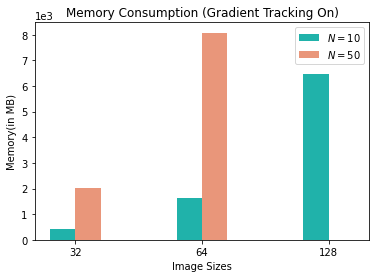

In [19]:
# Import Library

import numpy as np 
import matplotlib.pyplot as plt 

# Define Data

img_sizes = ['32', '64','128']
step_10 = [403.887616, 1622.050304, 6460.294656]
step_50 = [2019.390976, 8078.337536, 0]
width = 0.2

x_axis = np.arange(len(img_sizes))

# Multi bar Chart

plt.bar(x_axis - 0.1, step_10, width=width, label = '$N=10$', color='lightseagreen')
plt.bar(x_axis +0.1, step_50, width=width, label = '$N=50$', color='darksalmon')

# Xticks

plt.xticks(x_axis, img_sizes)

# Add labels

plt.xlabel("Image Sizes")
plt.ylabel("Memory(in MB)")

# Add legend
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.legend()
plt.title("Memory Consumption (Gradient Tracking On)")

# Display

plt.show()

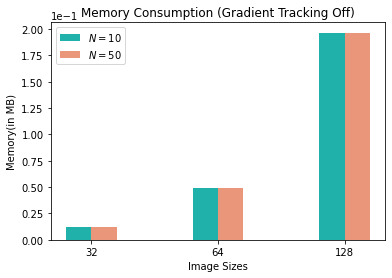

In [22]:
# Define Data

img_sizes = ['32', '64','128']
step_10 = [0.012288, 0.049152, 0.196608]
step_50 = [0.012288, 0.049152, 0.196608]
width = 0.2

x_axis = np.arange(len(img_sizes))

# Multi bar Chart

plt.bar(x_axis - 0.1, step_10, width=width, label = '$N=10$', color='lightseagreen')
plt.bar(x_axis +0.1, step_50, width=width, label = '$N=50$', color='darksalmon')

# Xticks

plt.xticks(x_axis, img_sizes)

# Add labels

plt.xlabel("Image Sizes")
plt.ylabel("Memory(in MB)")

# Add legend
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.legend()
plt.title("Memory Consumption (Gradient Tracking Off)")

# Display 
plt.show()